## Redshift Data API in Python 
- [Sample GitHub](https://github.com/aws-samples/getting-started-with-amazon-redshift-data-api/blob/main/use-cases/sagemaker-notebook-redshift-ml/redshift_ml_with_data_api.ipynb)

In [49]:
import boto3
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Connection Information

In [36]:
DATABASE = "sample_data_dev"
USER = "demo"
REDSHIFT_ENDPOINT="redshiftcluster-785zisrqau5g.cfzjcdjgohw7.ap-southeast-1.redshift.amazonaws.com:5439/demo"

## Client and Execute SQL

In [41]:
session = boto3.session.Session()
region = session.region_name

def run_sql(sql_text):
    client = boto3.client("redshift-data")
    res = client.execute_statement(
        Database=DATABASE, 
        DbUser=USER, 
        Sql=sql_text,
        ClusterIdentifier=REDSHIFT_ENDPOINT.split('.')[0]
    )
    query_id = res["Id"]
    done = False
    while not done:
        time.sleep(1)
        status_description = client.describe_statement(Id=query_id)
        status = status_description["Status"]
        if status == "FAILED":
            raise Exception('SQL query failed:' + query_id + ": " + status_description["Error"])
        elif status == "FINISHED":
            if status_description['ResultRows']>0:
                results = client.get_statement_result(Id=query_id)
                column_labels = []
                for i in range(len(results["ColumnMetadata"])): column_labels.append(results["ColumnMetadata"][i]['label'])
                records = []
                for record in results.get('Records'):
                    records.append([list(rec.values())[0] for rec in record])
                df = pd.DataFrame(np.array(records), columns=column_labels)
                return df
            else:
                return query_id

## Send Sample Queries 

Fin top customer by purchase from customer and orders table 

In [56]:
query_1 = """
select c_name, sum(o_totalprice) as total_purchase from (
  select c_name, o_totalprice from {0}.customer, {0}.orders
  where customer.c_custkey = orders.o_custkey
) group by c_name order by total_purchase desc limit 10;
""".format("tpch")

In [57]:
df = run_sql(query_1)

In [58]:
df

,c_name,total_purchase
0,Customer#000143500,7012696.48
1,Customer#000095257,6563511.23
2,Customer#000087115,6457526.26
3,Customer#000131113,6311428.86
4,Customer#000103834,6306524.23
5,Customer#000134380,6291610.15
6,Customer#000069682,6287149.42
7,Customer#000102022,6273788.41
8,Customer#000098587,6265089.35
9,Customer#000085102,6135483.63


In [98]:
names = [x.split('#')[-1][-3:] for x in df.c_name.to_list()]

In [102]:
df = df.astype({"total_purchase": "float"})

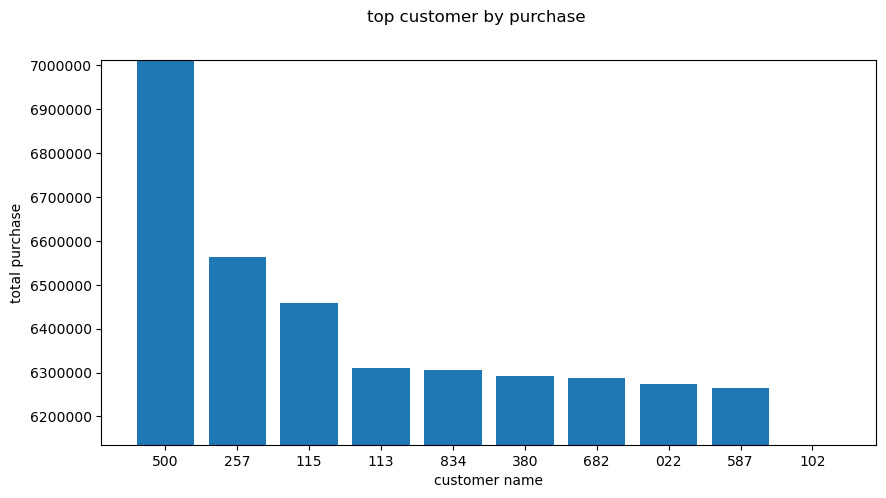

In [107]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
axes.bar(names, df.total_purchase)
axes.set_ylabel('total purchase')
axes.set_xlabel('customer name')
axes.ticklabel_format(useOffset=False, style='plain', axis='y')
axes.set_ylim(6135483.63, 7012696.48)
fig.suptitle('top customer by purchase')
plt.show()